# Imports

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from skopt.space import Integer
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv(r'C:\Users\rraks\Downloads\perrin-freres-monthly-champagne.csv')
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [3]:
df.shape

(107, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
df.Month = pd.to_datetime(df.Month,format='%Y-%m')

In [7]:
df = df.set_index(df.Month)

In [8]:
df = df.drop(columns=['Month'])

In [9]:
df = df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72':'Sales'})

In [10]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


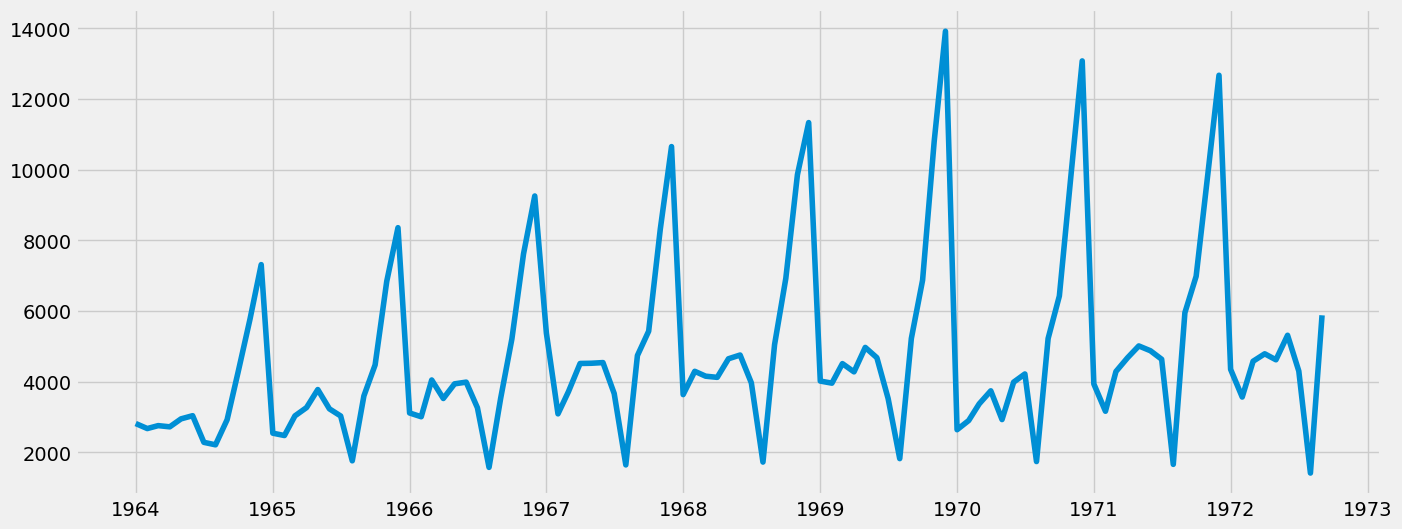

In [11]:
plt.figure(figsize=(15,6))
plt.plot(df)

# Train Test Split

In [12]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [13]:
train = df.loc[df.index<='1971-01-01']
test = df.loc[df.index>='1971-01-01']

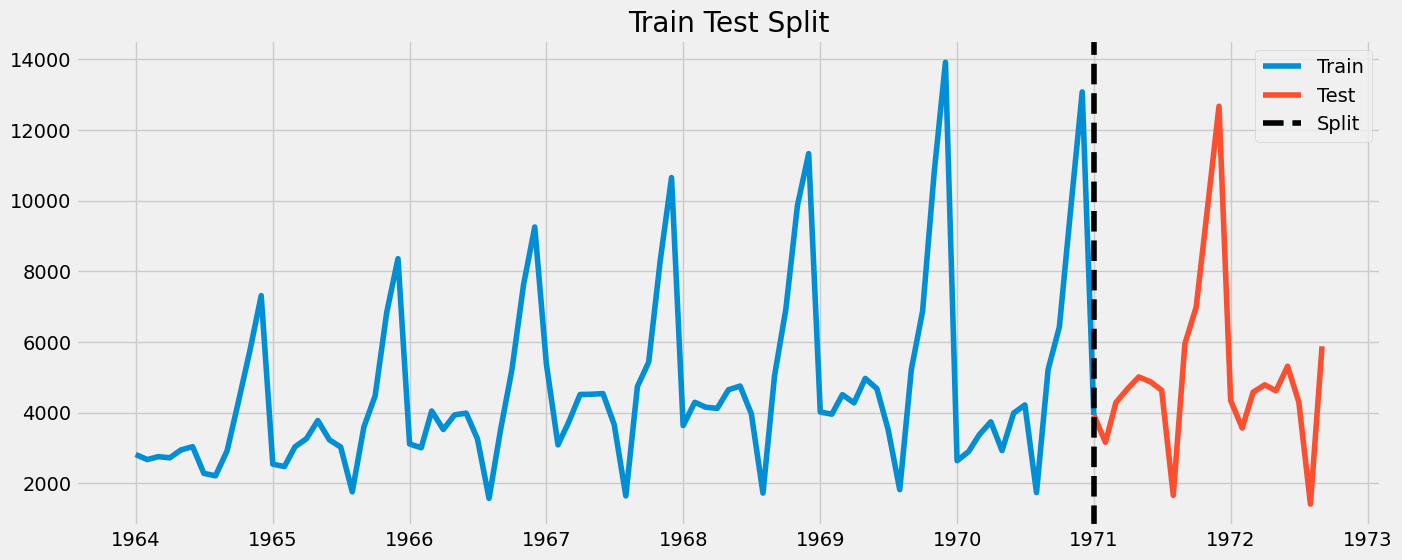

In [14]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split')
plt.axvline(pd.Timestamp('1971-01-01'),ls = '--',color = 'black')
plt.legend(['Train','Test','Split'])

# Decomposition

In [15]:
decomp_results = seasonal_decompose(train)

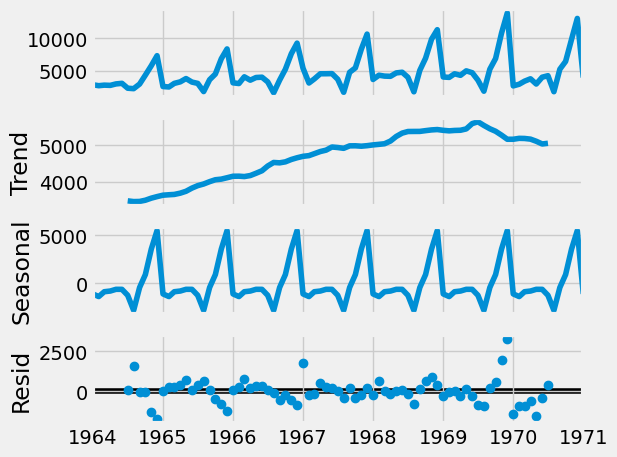

In [16]:
decomp_results.plot()
plt.show()

# Differencing

In [17]:
test_results = adfuller(train)
test_results

(-2.2011037037495993,
 0.20584511996449495,
 11,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 1177.3297071030865)

In [18]:
train1 = train.diff()
train1.dropna(inplace=True)
train1

,Sales
Month,
1964-02-01,-143.0
1964-03-01,83.0
1964-04-01,-34.0
1964-05-01,225.0
1964-06-01,90.0
...,...
1970-09-01,3483.0
1970-10-01,1203.0
1970-11-01,3418.0


<Axes: xlabel='Month'>

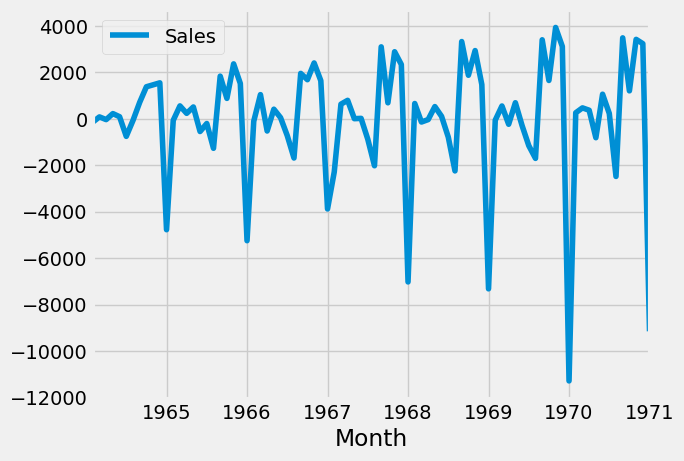

In [19]:
train1.plot()

In [20]:
test_results = adfuller(train1)
test_results

(-23.879553834493674,
 0.0,
 10,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 1167.4658753642118)

# ACF PACF Plots

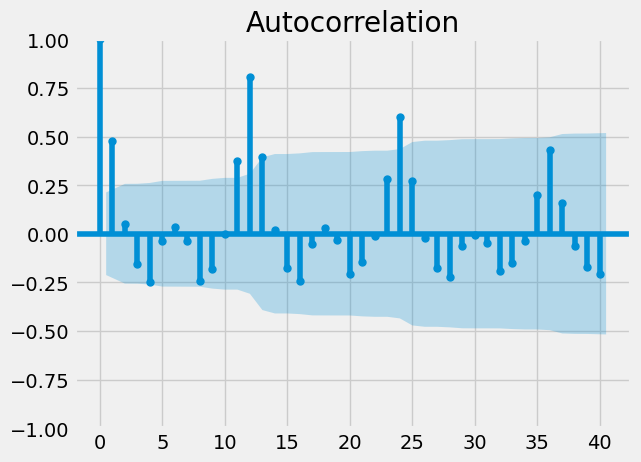

In [21]:
acf = plot_acf(train, lags=40)

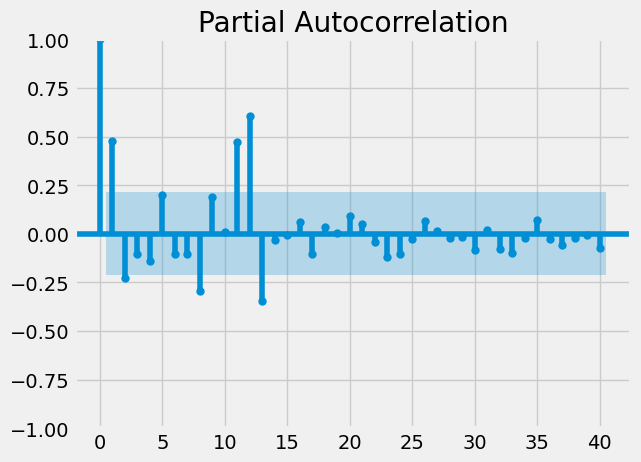

In [22]:
pacf = plot_pacf(train,lags=40)

<Axes: xlabel='Month'>

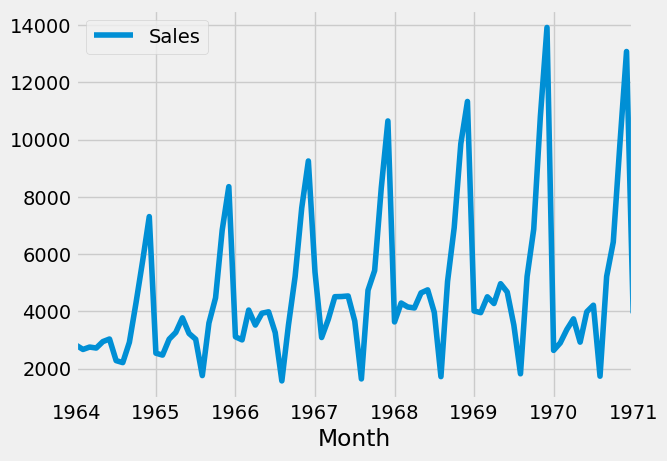

In [23]:
train.plot()

# Arima

In [24]:
model = ARIMA(train.Sales, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()
preds = model_fit.predict(start='1971-01-01',end='1972-09-01')

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


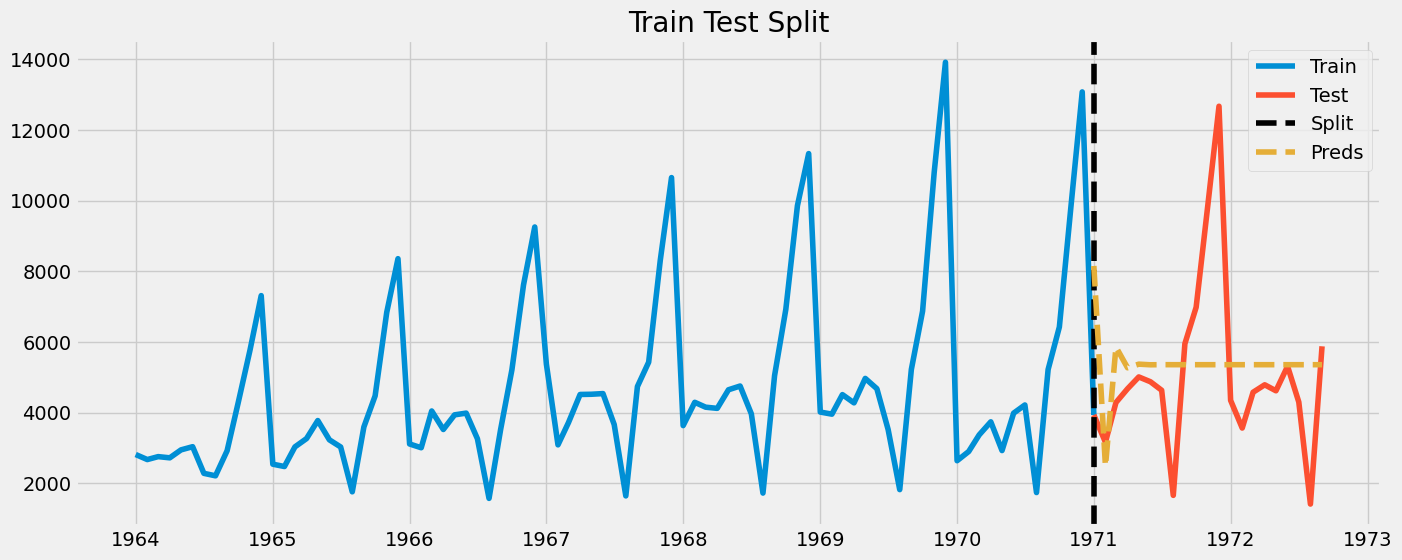

In [25]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split')
plt.axvline(pd.Timestamp('1971-01-01'),ls = '--',color = 'black')
plt.plot(preds,ls='--')
plt.legend(['Train','Test','Split','Preds'])

# Tuned Arima

In [29]:
p =q = range(0,3)
d = 1

In [30]:
pdq = list(itertools.product(p,[d],q))

In [31]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [32]:
best_mae = np.inf
for param in pdq:
    model = ARIMA(train,order=param)
    model_fit = model.fit()
    preds = model_fit.predict(start='1971-01-01',end='1972-09-01')
    mae = mean_absolute_error(test,preds)
    if mae<best_mae:
        best_mae = mae
        best_param = param

print(f'best_param = {best_param}')
print(f'best_score = {best_mae}')   

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

best_param = (2, 1, 2)
best_score = 1712.2823489780026


In [33]:
model = ARIMA(train.Sales, order=best_param)
model_fit = model.fit()
model_fit.summary()
preds = model_fit.predict(start='1971-01-01',end='1972-09-01')

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


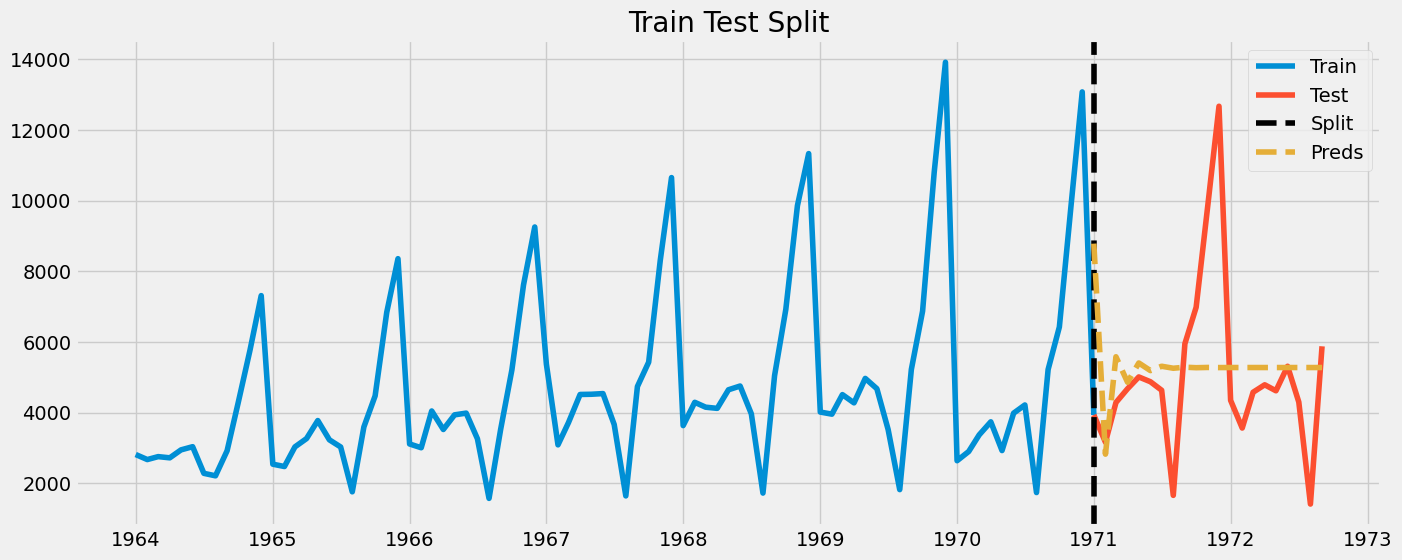

In [34]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split')
plt.axvline(pd.Timestamp('1971-01-01'),ls = '--',color = 'black')
plt.plot(preds,ls='--')
plt.legend(['Train','Test','Split','Preds'])

# Sarimax

In [35]:
model = SARIMAX(train.Sales, order=(1,1,0),seasonal_order=(1,1,0,12))
model_fit = model.fit()
model_fit.summary()
preds = model_fit.predict(start='1971-01-01',end='1972-09-01')

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


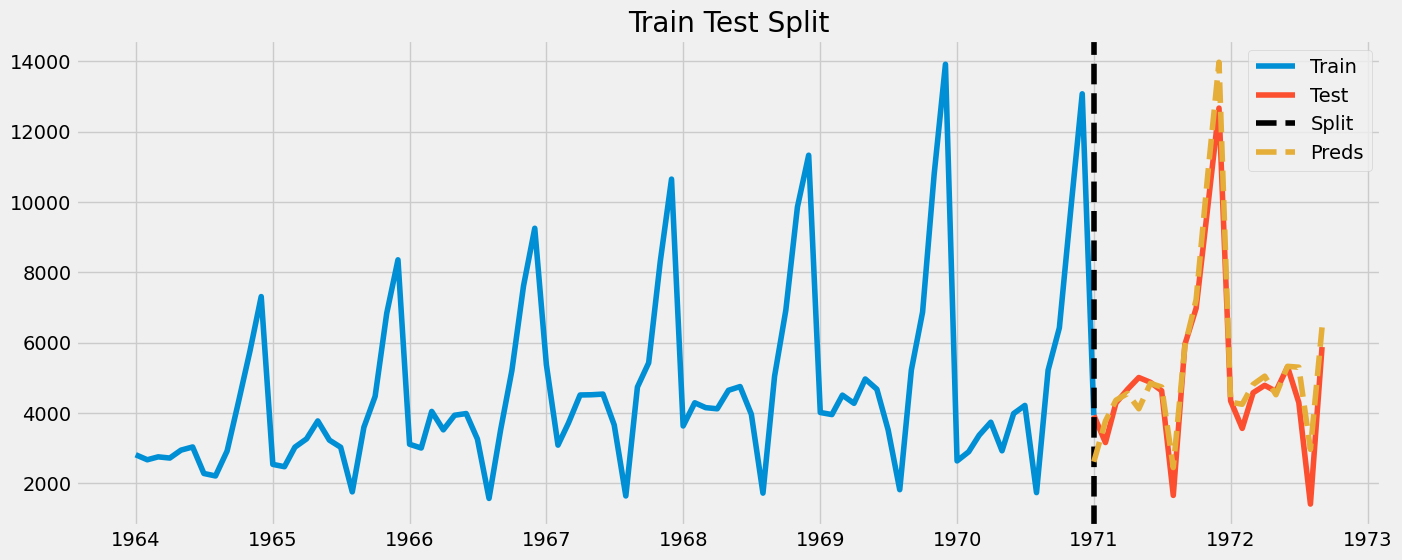

In [36]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split')
plt.axvline(pd.Timestamp('1971-01-01'),ls = '--',color = 'black')
plt.plot(preds,ls='--')
plt.legend(['Train','Test','Split','Preds'])

In [37]:
mse = mean_squared_error(test,preds)
mae = mean_absolute_error(test,preds)
mape = mean_absolute_percentage_error(test,preds)
rmse = np.sqrt(mse)

In [38]:
print(f'MSE : {mse : .2f}')
print(f'MAE : {mae : .2f}')
print(f'MAPE : {mape : .2f}')
print(f'RMSE : {rmse : .2f}')

MSE :  500655.96
MAE :  519.11
MAPE :  0.15
RMSE :  707.57


In [39]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000



# Tuned Sarimax

In [40]:
p = q = range(0,3)
d = 1
s = 12

In [41]:
pdq_sarimax = list(itertools.product(p,[d],q,))
pdq_sarimax_s = list(itertools.product(p,[d],q,[s]))

In [42]:
pdq_sarimax

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [43]:
best_mae = np.inf

try:
    for param in pdq_sarimax:
        for sparam in pdq_sarimax_s:
            model = SARIMAX(train,order=param, seasonal_order=sparam,n_jobs=-1)
            model_fit = model.fit()
            preds = model_fit.predict(start='1971-01-01',end='1972-09-01')
            mae = mean_absolute_error(test,preds)
            if mae<best_mae:
                best_mae = mae
                best_param = param
                best_param_s = sparam
except:
    print("error with param",param,sparam)
print(f'best_param = {best_param}')
print(f'best_params = {best_param_s}')
print(f'best_mae = {best_mae}')   

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\rraks\AppData\

best_param = (1, 1, 0)
best_params = (1, 1, 1, 12)
best_mae = 497.18131237086016


In [44]:
model = SARIMAX(train.Sales, order=best_param,seasonal_order=best_param_s)
model_fit = model.fit()
model_fit.summary()
preds = model_fit.predict(start='1971-01-01',end='1972-09-01')

C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rraks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


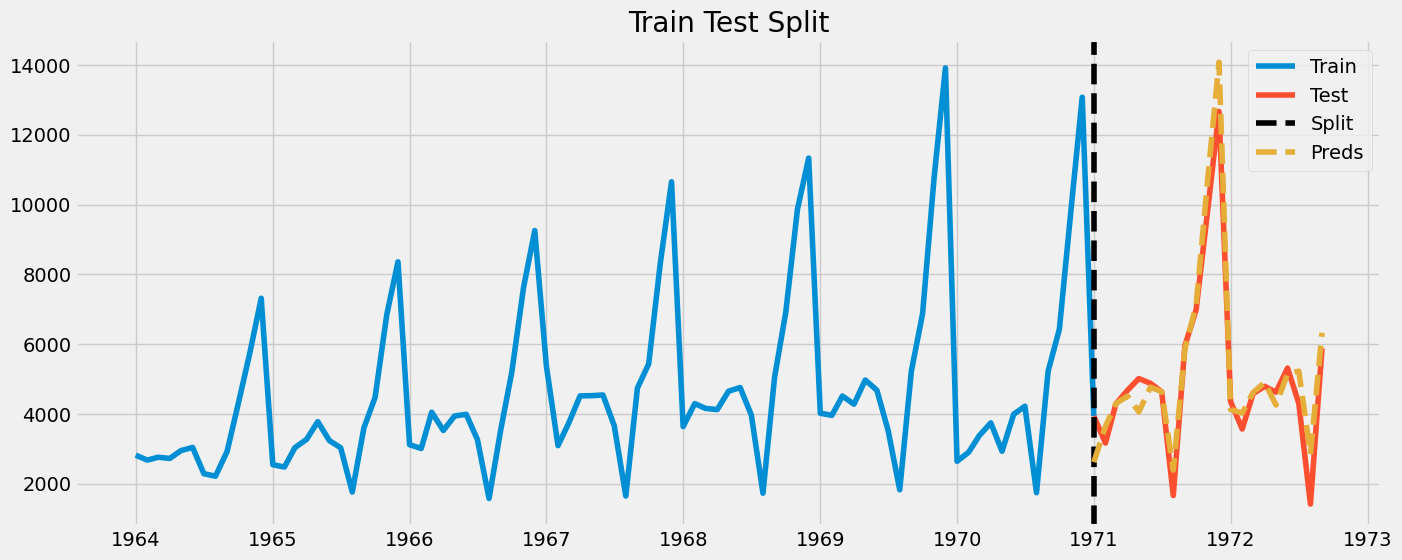

In [45]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split')
plt.axvline(pd.Timestamp('1971-01-01'),ls = '--',color = 'black')
plt.plot(preds,ls='--')
plt.legend(['Train','Test','Split','Preds'])

In [46]:
mse = mean_squared_error(test,preds)
mae = mean_absolute_error(test,preds)
mape = mean_absolute_percentage_error(test,preds)
rmse = np.sqrt(mse)

In [47]:
print(f'MSE : {mse : .2f}')
print(f'MAE : {mae : .2f}')
print(f'MAPE : {mape : .2f}')
print(f'RMSE : {rmse : .2f}')
print('Best_Param :',best_param,best_param_s)

MSE :  465112.57
MAE :  497.18
MAPE :  0.14
RMSE :  681.99
Best_Param : (1, 1, 0) (1, 1, 1, 12)
